In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
from konlpy.tag import Okt #형태소 분석
from nltk import bigrams
from nltk.util import ngrams
import pandas as pd

from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel # 토픽 개수 검증
from tqdm import tqdm
# from tqdm.notebook import tqdm
from gensim import corpora
from gensim.models import TfidfModel

import warnings
warnings.filterwarnings(action='ignore')

from modules import *

In [2]:
okt=Okt()

In [3]:
#원하는 태그 추출 & 불용어 제거
def okt_pos_tagging(string):
    
    #불용어
    stopwords = pd.read_csv('ko-stopwords.csv')
    stopwords=list(stopwords['stopwords'])
    stopwords.extend(['에서','고','이다','는','한','씨', "것","거","게","데","이다","건","고","되다","되어다","걸","기",
                      "시","네","듯","랍니","중이","얘","스","도도", "나","수","개","내","기","제","저","인","있다","이렇다",
                      "그렇다","번","위","팅","분","인","링","란","포","두", "진짜", "하다" ,"이다" ,"가다", "이제" ,"들다",
                     "너무", "먹다"])
    stopwords=set(stopwords)    
    pos_words = okt.pos(string, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Adjective', 'Verb'] if word not in stopwords ]
    return words


#bigram 만드는 함수
def bigram_(tokens):
    
    #document 별 형태소분석기로 분리된 토큰들을 bigram으로 변환(토큰은 string 상태)
    bigram_stack = [] #변환된 bigram
    for token in tokens:
        bigram = bigrams(token)
        bigram_token = [' '.join(grams) for grams in bigram]
        bigram_stack.append(bigram_token)
        
    #bigram  딕셔너리 생성(아이디 매칭)
    id2word = corpora.Dictionary(bigram_stack) #unigram
    #id2word.token2id  #아이디가 매칭된 딕셔너리 확인용

    #딕셔너리에 매칭한 corpus 생성
    #생성한 bigram 딕셔너리에서 bigram_stack의 토큰을 아이디로 매칭변환
    texts = bigram_stack 
    corpus = [id2word.doc2bow(text) for text in texts]
    
    #gensim으로 tf-idf 처리 #바이그램 요소 하나를 하나의 워드로 처리해서 tf_idf 점수
    tfidf = TfidfModel(corpus) 
    corpus_tfidf = tfidf[corpus]
    tfidf_corpus = [x for x in corpus_tfidf]
    return tfidf_corpus, corpus ,id2word


#perplexcity 계산(그래프 생성, 테이블 생성)
def perplexcity_graph(topic_n, bigram_result):
    #topic_n _ 몇개 토픽을 테스트 해볼것인지 지정    
    #perplexcity
    perplexity_value = []
    num_t = []
    for i in topic_n:
        model = LdaModel(bigram_result[0], num_topics = i, id2word=bigram_result[2])
        num_t.append(i)
        perplexity_value.append(model.log_perplexity(bigram_result[1]))

    #그래프
    plt.title('Perpelxity score')
    plt.plot(topic_n, perplexity_value)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity_scores')
    plt.show
    plt.savefig('Perplexity_Graph.png')  #그래프저장
    
    #테이블 저장
    perplexity_df = pd.DataFrame(list(zip(num_t,perplexity_value)), columns = ['cluster','perplexity_score'])
    perplexity_df.to_csv('Perplexity_score_table.csv', encoding='utf-8-sig')
    perplexity_df


#coherence 계산(그래프 생성, 테이블 생성)    
def coherence_graph(topic_n, bigram_result):
    coherence_value = []
    num_t = []

    for i in topic_n:
        model = LdaModel(bigram_result[0], num_topics = i, id2word=bigram_result[2])
        cm = CoherenceModel(model=model, corpus=bigram_result[1], coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_value.append(coherence)
        num_t.append(i)

    #그래프
    plt.title('Coherence score')
    plt.plot(topic_n, coherence_value)
    plt.xlabel('number of topics')
    plt.ylabel('coherence_scores')
    plt.show
    plt.savefig('Coherence_Graph.png')  #그래프저장

    #테이블 저장
    coherence_df = pd.DataFrame(list(zip(num_t,coherence_value)), columns = ['cluster','coherence_score'])
    coherence_df.to_csv('Coherence_score_table.csv', encoding='utf-8-sig')
    coherence_df

    
#doc 문서별 토픽 추출하기
def exctract_topic(ldamodel, corpus):
    topic_n = []
    topic_prop = []
    all_topic_prop = []
    for topic_doc in ldamodel[corpus]:
        topic_doc = sorted(topic_doc, key=lambda x: (x[1]), reverse=True) #여러 토픽이 할당되어 있는경우 높은 확률의 토픽순으로 정렬
        
        #확률 기준대로 정렬 했으므로 topic_doc[0] 제일 높은 확률의 토픽
        topic_n.append(int(topic_doc[0][0]))
        topic_prop.append(round(topic_doc[0][1],4))
        all_topic_prop.append(topic_doc)
        
    #데이터프레임화    
    data = {'topic':topic_n, 'topic_weight' : topic_prop ,'topic_all_weight': all_topic_prop}
    df = pd.DataFrame(data)
    return df

In [4]:
data = pd.read_csv('을지로신당 술집_clustering(2022).csv')
text_data = data.reset_index(drop=True)
del text_data['Unnamed: 0']
text_data

,time,review,comment,like,url,doc,token,text_noun,클러스터
0,2022. 10. 27. 21:09,수원맛집 [수원역] 하식당 | 분위기 좋은 감성술집 추천 ...,[],11,https://blog.naver.com/khj_1212/222912513272,수원맛집 수원역 하식당 분위기 좋은 감성술집 추천 띠디니 복사 이웃추가 본문 기타...,"['수원', '수원역', '식당', '분위기', '감성', '띠디', '도지', '...","['수원', '수원역', '식당', '분위기', '감성', '띠디', '도지', '...",0
1,2022. 3. 10. 12:53,맛집 전주한옥마을 이색 술집 : 미스테리 대저택 ...,[],10,https://blog.naver.com/selly_ka/222668706362,맛집 전주한옥마을 이색 술집 미스테리 대저택 바몬 복사 이웃추가 본문 기타 기능 ...,"['옥', '마을', '이색', '미스테리', '저택', '바몬', '도지', '전...","['옥', '마을', '이색', '미스테리', '저택', '바몬', '도지', '전...",2
2,2022. 10. 19. 22:02,맛집 마곡나루역 나룻목 분위기좋은 신상 술집(소개팅 장소 추천...,[],8,https://blog.naver.com/alice7743/222904875596,맛집 마곡나루역 나룻목 분위기좋은 신상 술집 소개팅 장소 추천 참새 복사 이웃추가...,"['마곡나루역', '나룻', '목', '분위기', '신상', '소개팅', '장소',...","['마곡나루역', '나룻', '목', '분위기', '신상', '소개팅', '장소',...",0
3,2022. 9. 8. 7:30,Reviewer 연남동카페｜공미학 마포점( 홍대주차꿀팁) ...,[],[],https://blog.naver.com/bliss_dion/222869421259,연남동카페 공미학 마포점 홍대주차꿀팁 프롬디온 복사 이웃추가 본문 기타 기능 지도...,"['연남동', '카페', '미학', '마포', '홍대', '주차', '꿀팁', '프...","['연남동', '카페', '미학', '마포', '홍대', '주차', '꿀팁', '프...",0
4,2022. 6. 10. 20:26,Pick [신부동술집] 레트로한 느낌의 실내포차 가맥집 장미맨...,[],34,https://blog.naver.com/s_star2/222767823438,신부동술집 레트로한 느낌의 실내포차 가맥집 장미맨숀 별빛청하 둡듀 복사 이웃추가 ...,"['신부동', '레트로', '느낌', '실내', '포차', '가맥집', '장미', ...","['신부동', '레트로', '느낌', '실내', '포차', '가맥집', '장미', ...",0
...,...,...,...,...,...,...,...,...,...
1035,2022. 5. 25. 10:00,맛집 제일 좋아♥ 일산 라페스타 술집 추천 :: 동굴에 온 것...,[],[],https://blog.naver.com/dugeng/222740758135,맛집 제일 좋아 일산 라페스타 술집 추천 동굴에 온 것 같은 이색 바 지느러미바 ...,"['제일', '일산', '페스', '타', '동굴', '온', '이색', '바', ...","['제일', '일산', '페스', '타', '동굴', '온', '이색', '바', ...",0
1036,2022. 1. 28. 9:00,맛있는식사 [서울대입구역] 샤로수길데이트 프렌치 와인바! 분위...,[],9,https://blog.naver.com/jja2896/222631355849,맛있는식사 서울대입구역 샤로수길데이트 프렌치 와인바 분위기좋은 술집 라밤바 쮸나 ...,"['식사', '서울', '대입', '구역', '샤', '데이트', '프렌치', '와...","['식사', '서울', '대입', '구역', '샤', '데이트', '프렌치', '와...",0
1037,2022. 1. 30. 23:10,냠냠굿 [성수 맛집] 분위기와 맛 모두 좋은 술집 온슬 ...,[],14,https://blog.naver.com/ddaann22/222635385152,냠냠굿 성수 맛집 분위기와 맛 모두 좋은 술집 온슬 말랑 복사 이웃추가 본문 기타...,"['굿', '성수', '분위기', '온슬', '말', '도지', '요즘', '세상'...","['굿', '성수', '분위기', '온슬', '말', '도지', '요즘', '세상'...",0
1038,2022. 9. 7. 16:28,술집 부산 서면 술집 : 샌부 사운드바 : sanbu soun...,[],[],https://blog.naver.com/dmswjd2827/222869373377,술집 부산 서면 술집 샌부 사운드바 분위기좋은 바 너굴스 복사 이웃추가 본문 기타...,"['부산', '서면', '새다', '부', '사운드', '바', '분위기', '바'...","['부산', '서면', '부', '사운드', '바', '분위기', '바', '너굴스...",0


In [5]:
# 사전에 클러스터링 한 결과가 있는 경우 활용
# 클러스터를 돌아가며 결과를 도출할 경우 cluster 번호를 하나씩 변경
text_data = data[data['클러스터']==1]
text_data = text_data.reset_index(drop=True)

In [6]:
del text_data['Unnamed: 0']
text_data.head()

,time,review,comment,like,url,doc,token,text_noun,클러스터
0,2022. 7. 14. 11:44,"대구 맛집 대구 반월당 술집, 레트로 술집에서 분위기 있는 한...",[],1,https://blog.naver.com/fullhouse2210/222811108622,대구 맛집 대구 반월당 술집 레트로 술집에서 분위기 있는 한잔 동성로 안주 맛집 ...,"['대구', '대구', '반월당', '레트로', '분위기', '한잔', '동성로',...","['대구', '대구', '반월당', '레트로', '분위기', '한잔', '동성로',...",1
1,2022. 10. 27. 21:34,맛집밥집술집탐방 대구 교동 와인바 위캔드 분위기 좋은 신상술집...,[],13,https://blog.naver.com/mh110392/222912533103,맛집밥집술집탐방 대구 교동 와인바 위캔드 분위기 좋은 신상술집 추천 미니 복사 이...,"['밥집', '탐방', '대구', '교동', '와인', '바', '위캔드', '분위...","['밥집', '탐방', '대구', '교동', '와인', '바', '위캔드', '분위...",1
2,2022. 10. 18. 15:10,맛집 대구 교동 술집 분위기 좋은 신상 와인바 위캔드 ...,[],9,https://blog.naver.com/d0background/222903608379,맛집 대구 교동 술집 분위기 좋은 신상 와인바 위캔드 바쁜애옹이집사 복사 이웃추가...,"['대구', '교동', '분위기', '신상', '와인', '바', '위캔드', '바...","['대구', '교동', '분위기', '신상', '와인', '바', '위캔드', '애...",1
3,2022. 10. 25. 9:36,먹고 마시기 [대구동성로와인바]비노. 와인바 파스타 치즈 분위...,[],9,https://blog.naver.com/yseulseul/222909780546,먹고 마시기 대구동성로와인바 비노 와인바 파스타 치즈 분위기 맛집 술집 저녁식사 ...,"['마시기', '대구', '동성로', '와인', '바', '비노', '와인', '바...","['마시기', '대구', '동성로', '와인', '바', '비노', '와인', '바...",1
4,2022. 10. 25. 23:05,쓰는 즐거움 대구 안주 맛집 90년대 레트로 감성 이색 술집 ...,[],6,https://blog.naver.com/mlikjoayo/222910575232,쓰는 즐거움 대구 안주 맛집 년대 레트로 감성 이색 술집 풀하우스 방방팅구 복사 ...,"['쓰다', '즐거움', '대구', '안주', '년대', '레트로', '감성', '...","['즐거움', '대구', '안주', '년대', '레트로', '감성', '이색', '...",1


### 한국어 토큰화
- 한국어 토큰을 완료한 후에 bigram과 tf-idf 점수를 기준으로 딕셔너리를 만들어 LDA에 적용될 수 있게 맵핑하는 작업

In [7]:
# 원문 데이터를 한국어 형태소 기준으로 토큰화 진행
# 기본 셋팅되어 있는 형태소는 명사, 형용사, 동사 입니다
# 형태소 변경이 필요할 경우 module.py 파일에서 변경
tokenizing_sent = []
for i in tqdm(text_data['doc']):
    tokenizing_sent.append(okt_pos_tagging(i))
text_data['tokenizing'] = tokenizing_sent
text_data   # 토큰화된 결과값을 기존의 원문 파일 테이블에 추가

100%|██████████| 45/45 [00:06<00:00,  7.21it/s]


,time,review,comment,like,url,doc,token,text_noun,클러스터,tokenizing
0,2022. 7. 14. 11:44,"대구 맛집 대구 반월당 술집, 레트로 술집에서 분위기 있는 한...",[],1,https://blog.naver.com/fullhouse2210/222811108622,대구 맛집 대구 반월당 술집 레트로 술집에서 분위기 있는 한잔 동성로 안주 맛집 ...,"['대구', '대구', '반월당', '레트로', '분위기', '한잔', '동성로',...","['대구', '대구', '반월당', '레트로', '분위기', '한잔', '동성로',...",1,"[대구, 맛집, 대구, 반월당, 술집, 레트로, 술집, 분위기, 한잔, 동성로, 안..."
1,2022. 10. 27. 21:34,맛집밥집술집탐방 대구 교동 와인바 위캔드 분위기 좋은 신상술집...,[],13,https://blog.naver.com/mh110392/222912533103,맛집밥집술집탐방 대구 교동 와인바 위캔드 분위기 좋은 신상술집 추천 미니 복사 이...,"['밥집', '탐방', '대구', '교동', '와인', '바', '위캔드', '분위...","['밥집', '탐방', '대구', '교동', '와인', '바', '위캔드', '분위...",1,"[맛집, 밥집, 술집, 탐방, 대구, 교동, 와인, 바, 위캔드, 분위기, 좋다, ..."
2,2022. 10. 18. 15:10,맛집 대구 교동 술집 분위기 좋은 신상 와인바 위캔드 ...,[],9,https://blog.naver.com/d0background/222903608379,맛집 대구 교동 술집 분위기 좋은 신상 와인바 위캔드 바쁜애옹이집사 복사 이웃추가...,"['대구', '교동', '분위기', '신상', '와인', '바', '위캔드', '바...","['대구', '교동', '분위기', '신상', '와인', '바', '위캔드', '애...",1,"[맛집, 대구, 교동, 술집, 분위기, 좋다, 신상, 와인, 바, 위캔드, 바쁘다,..."
3,2022. 10. 25. 9:36,먹고 마시기 [대구동성로와인바]비노. 와인바 파스타 치즈 분위...,[],9,https://blog.naver.com/yseulseul/222909780546,먹고 마시기 대구동성로와인바 비노 와인바 파스타 치즈 분위기 맛집 술집 저녁식사 ...,"['마시기', '대구', '동성로', '와인', '바', '비노', '와인', '바...","['마시기', '대구', '동성로', '와인', '바', '비노', '와인', '바...",1,"[마시기, 대구, 동성로, 와인, 바, 비노, 와인, 바, 파스타, 치즈, 분위기,..."
4,2022. 10. 25. 23:05,쓰는 즐거움 대구 안주 맛집 90년대 레트로 감성 이색 술집 ...,[],6,https://blog.naver.com/mlikjoayo/222910575232,쓰는 즐거움 대구 안주 맛집 년대 레트로 감성 이색 술집 풀하우스 방방팅구 복사 ...,"['쓰다', '즐거움', '대구', '안주', '년대', '레트로', '감성', '...","['즐거움', '대구', '안주', '년대', '레트로', '감성', '이색', '...",1,"[쓰다, 즐거움, 대구, 안주, 맛집, 년대, 레트로, 감성, 이색, 술집, 풀하우..."
5,2022. 9. 3. 12:32,국내 맛집 대구 교동 술집 <띵띵> 분위기에 취하고 와인에 취...,[],23,https://blog.naver.com/nothingbutfun/222865617534,국내 맛집 대구 교동 술집 띵띵 분위기에 취하고 와인에 취한 감성가득 술집 자스민...,"['국내', '대구', '교동', '띵띵', '분위기', '취하', '와인', '취...","['국내', '대구', '교동', '분위기', '취하', '와인', '취한', '감...",1,"[국내, 맛집, 대구, 교동, 술집, 분위기, 취하, 와인, 취한, 감성, 가득, ..."
6,2022. 1. 18. 22:08,취미 [대구맛집 / 대구와인바 / 삼덕동술집] 소바쥬 ...,[],3,https://blog.naver.com/wldo1879/222625248857,취미 대구맛집 대구와인바 삼덕동술집 소바쥬 지애 복사 이웃추가 본문 기타 기능 지...,"['취미', '대구', '대구', '와인', '바', '삼덕동', '소바', '쥬'...","['취미', '대구', '대구', '와인', '바', '삼덕동', '소바', '쥬'...",1,"[취미, 대구, 맛집, 대구, 와인, 바, 삼덕동, 술집, 소바, 쥬, 지애, 복사..."
7,2022. 1. 3. 16:15,맛집공개 대구핫플 가볼만한곳 '대화의장' 먹로그 ...,[],4,https://blog.naver.com/21applebox/222611805678,맛집공개 대구핫플 가볼만한곳 대화의장 먹로그 복사 이웃추가 본문 기타 기능 지도로...,"['공개', '핫', '대화', '의장', '로그', '도지', '핫', '대화',...","['공개', '핫', '대화', '의장', '로그', '도지', '핫', '대화',...",1,"[맛집, 공개, 핫, 가보다, 곳, 대화, 의장, 로그, 복사, 이웃, 추가, 본문..."
8,2022. 1. 29. 21:07,냠냠굿 리뷰 [대구 / 교동] 벌써 3번째 방문인 “대화...,[],8,https://blog.naver.com/ensdl98/222634663394,냠냠굿 리뷰 대구 교동 벌써 번째 방문인 대화의 장 대구 교동 카페 맛집 교동 술...,"['굿', '리뷰', '대구', '교동', '벌써', '대화', '장', '대구',...","['굿', '리뷰', '대구', '교동', '벌써', '대화', '장', '대구',...",1,"[굿, 리뷰, 대구, 교동, 벌써, 방문, 대화, 장, 대구, 교동, 카페, 맛집,..."
9,2022. 5. 26. 12:06,먹방 대구 대봉동 한옥 와인바 '소나무' 지오...,[],33,https://blog.naver.com/leejiw52/222746286621,먹방 대구 대봉동 한옥 와인바 소나무 지오니 복사 이웃추가 본문 기타 기능 지도로...,"['먹방', '대구', '대봉동', '옥', '와인', '바', '소나무', '지오...","['먹방', '대구', '대봉동', '옥', '와인', '바', '소나무', '지오...",1,"[먹방, 대구, 대봉동, 옥, 와인, 바, 소나무, 지오, 복사, 이웃, 추가, 본..."


In [8]:
# bigram을 적용하여 tf-idf 기준으로 토큰과 맵핑
# 데이터프레임 형태의 tokenizing 된 단어들을 bigram 형태로 변환하기 위한 작업

texts = text_data['tokenizing']
bigram_result = bigram_(texts)

bigram_result

([[(0, 0.04755914725027074),
   (1, 0.04755914725027074),
   (2, 0.04755914725027074),
   (3, 0.04755914725027074),
   (4, 0.04755914725027074),
   (5, 0.04755914725027074),
   (6, 0.04755914725027074),
   (7, 0.05490275405096509),
   (8, 0.04755914725027074),
   (9, 0.06766691747505893),
   (10, 0.04755914725027074),
   (11, 0.04755914725027074),
   (12, 0.0038749702515626667),
   (13, 0.03023925670838587),
   (14, 0.04755914725027074),
   (15, 0.03023925670838587),
   (16, 0.04755914725027074),
   (17, 0.0388992019793283),
   (18, 0.04755914725027074),
   (20, 0.0038749702515626667),
   (21, 0.04755914725027074),
   (22, 0.0038749702515626667),
   (23, 0.04755914725027074),
   (24, 0.0388992019793283),
   (25, 0.04755914725027074),
   (26, 0.04755914725027074),
   (27, 0.0024455662123971603),
   (28, 0.04755914725027074),
   (29, 0.04755914725027074),
   (30, 0.04755914725027074),
   (31, 0.04755914725027074),
   (32, 0.04755914725027074),
   (33, 0.04755914725027074),
   (34, 0.0676

### LDA 토픽 갯수 테스트
#### perplexcity score & coherence score
- 적절한 Elbow point와 클러스터링된 원문을 보고 적절할 토픽 갯수를 선정
- check_topic_n 변수에 테스트해볼 토픽의 갯수를 입력
- 토픽의 갯수는 range를 사용해서 입력

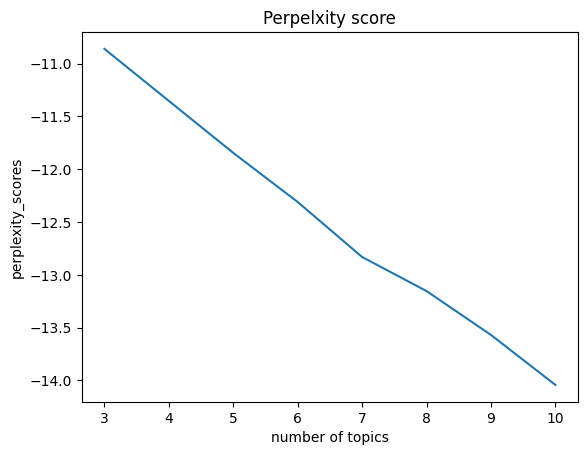

In [9]:
check_topic_n = range(3,11)

# perplexcity score : 복잡도 -> 낮을수록 좋음
perplexcity_graph(check_topic_n, bigram_result)

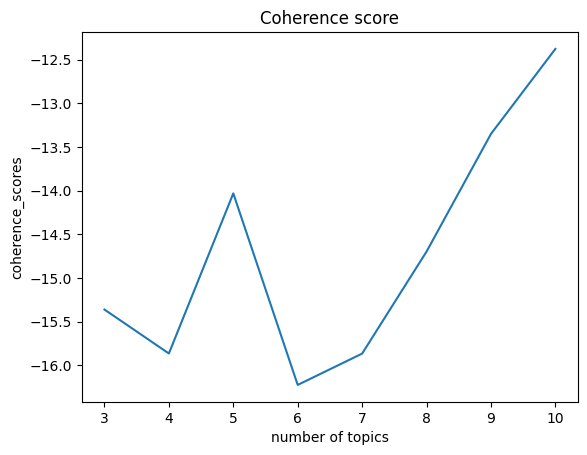

In [10]:
# coherence score : 일관성 -> 높을수록 좋음
# perplexcity와 coherence는 완벽한 정답이 아니므로 추가 판단 필요

# 토픽의 갯수에 따라 달라지는 coherence 점수를 보여줌
# png와 csv파일로 저장됨
coherence_graph(check_topic_n, bigram_result)

### LDA 시각화
- pyLDAvis Lib를 활용해 LDA를 시각화
- 토픽별 할당된 documents 확인

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### 라이브러리 테스트
- pyLDAvis 라이브러리 테스트 -> lda시각화가 잘 실행되는지 확인
- 오류나면 라이브러리 설치가 제대로 되었는지 확인

In [12]:
model = LdaModel(bigram_result[0], num_topics=5, id2word=bigram_result[2])
visual = gensimvis.prepare(model, bigram_result[1], bigram_result[2])
pyLDAvis.display(visual)

### LDA시각화 실행 및 저장
- check_topic_n에서 설정했던 토픽의 갯수별로 시각화된 LDA가 저장
- 저장된 파일은 html 확장자
- topic 개수를 새로 정하고 싶으면 check_topic_n 대신 range(n,m)을 넣어주면 됨
- 시각화 파일과 함께 대조하여 원문을 확인할 수 있도록 토픽 개수에 따른 원문도 저장됨

#### 토픽 할당, 할당된 document 추출(원문 검토시 활용)
- document 별로 해당하는 document가 몇 번 토픽에 할당되었는지를 보여줌
- topic_weight 컬럼은 topic 컬럼에서의 해당 토픽일 확률
- topic_all_weight 컬럼은 설정한 모든 토픽에 대하여 해당 document가 각 토픽에 할당될 확률


In [13]:
for i in tqdm(check_topic_n):
    # lda 시각화된 결과 저장
    model = LdaModel(bigram_result[0], num_topics=i, id2word=bigram_result[2])
    visual = gensimvis.prepare(model, bigram_result[1], bigram_result[2])
    pyLDAvis.save_html(visual, 'LDA토픽추출_시각화_topic_n{}.html'.format(i))

    # lda 데이터프레임 저장(원문, 토픽 넘버 매칭)
    lda_result = exctract_topic(model, bigram_result[1])
    df = pd.concat([text_data, lda_result], axis=1)
    df.to_csv('LDA토픽추출_원문_topic_n{}.csv'.format(i), encoding='utf-8-sig')
    

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]
